<a href="https://colab.research.google.com/github/mswastik/forecasting/blob/main/SARIMAv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 17.1MB/s 
     |████████████████████████████████| 2.1MB 47.5MB/s 
     |████████████████████████████████| 808kB 45.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


In [1]:
import pmdarima as pmd
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import plotly.express as px
import cufflinks as cf
import plotly.tools as tls

In [2]:
!git clone -l -s https://github.com/mswastik/forecasting.git cloned-repo
%cd cloned-repo

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo


In [ ]:
warnings.filterwarnings("ignore")
df = pd.read_excel('Forecasting1.xlsx',sheet_name='SO',index_col='del date')
df.rename({'agg':'agg1'},axis=1,inplace=True)
#df.drop('agg',inplace=True,axis=1)
df1 = df.loc[df['agg1']=='Tmmthpkhti Limi mm'].copy()
df1 = df1.groupby(by='del date').sum()
df1 = df1.resample('M').sum()
df1.drop(['wt','cs size'],inplace=True,axis=1)
df1

In [52]:
df['dd']=df.index.copy()
df['month'] = df['dd'].dt.year.astype('str')+"-"+df['dd'].dt.month.astype('str')
df2=df.groupby(['month','agg1']).sum().copy()
df2.drop(['wt','cs size'],inplace=True,axis=1)

In [67]:
toot=df2.loc[(slice(None),'Tmmthpkhti Limi Yih'),:]

In [68]:
toot.reset_index(level=1,inplace=True)
toot.drop(['tonn','agg1'],axis=1,inplace=True)

In [69]:
toot

,cases
month,
2012-10,5143.0
2012-11,8220.0
2012-12,5631.0
2013-1,20630.0
2013-10,10295.0
...,...
2020-5,2150.0
2020-6,59975.0
2020-7,52193.0


In [ ]:
def evaluate_arima_model(X, arima_order,s_order):
    splits = TimeSeriesSplit(n_splits=3)
    error=[]
    # make predictions
    for train_index, test_index in splits.split(X):
        train = X.values[train_index]
        test = X.values[test_index]
        model = SARIMAX(train, order=arima_order,seasonal_order=s_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        error.append(rmse(test.T[0], yhat))
    return np.asarray(error).mean()
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, m):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in p_values:
                    for D in d_values:
                        for Q in q_values:
                            order = (p,d,q)
                            s_order = (P,D,Q,m)
                            try:
                                mse = evaluate_arima_model(dataset, order,s_order)
                                if mse < best_score:
                                    best_score, best_cfg = mse, (order,s_order)
                                print('SARIMA%sx%s RMSE=%.3f' % (order,s_order,mse))
                            except:
                                continue
    print('Best SARIMA %s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
evaluate_arima_model(df1, (1,1,2),(0,0,0,12))

1157.5092213207224

In [ ]:
p_values = [0,1,2,3,4]
d_values = range(0, 2)
q_values = range(0, 4)
evaluate_models(df1, p_values, d_values, q_values,12)

SARIMA(0, 0, 0)x(0, 0, 0, 12) RMSE=1716.003
SARIMA(0, 0, 0)x(0, 0, 1, 12) RMSE=1554.912
SARIMA(0, 0, 0)x(0, 0, 2, 12) RMSE=1437.645
SARIMA(0, 0, 0)x(0, 0, 3, 12) RMSE=1374.687
SARIMA(0, 0, 0)x(0, 1, 0, 12) RMSE=1177.831
SARIMA(0, 0, 0)x(0, 1, 1, 12) RMSE=1152.103
SARIMA(0, 0, 0)x(0, 1, 2, 12) RMSE=1182.464
SARIMA(0, 0, 0)x(0, 1, 3, 12) RMSE=1179.829
SARIMA(0, 0, 0)x(1, 0, 0, 12) RMSE=1241.914
SARIMA(0, 0, 0)x(1, 0, 1, 12) RMSE=1274.391
SARIMA(0, 0, 0)x(1, 0, 2, 12) RMSE=1312.642
SARIMA(0, 0, 0)x(1, 0, 3, 12) RMSE=1308.297
SARIMA(0, 0, 0)x(1, 1, 0, 12) RMSE=1181.554
SARIMA(0, 0, 0)x(1, 1, 1, 12) RMSE=1197.323
SARIMA(0, 0, 0)x(1, 1, 2, 12) RMSE=1199.893
SARIMA(0, 0, 0)x(1, 1, 3, 12) RMSE=1179.862
SARIMA(0, 0, 0)x(2, 0, 0, 12) RMSE=1341.675
SARIMA(0, 0, 0)x(2, 0, 1, 12) RMSE=1317.626
SARIMA(0, 0, 0)x(2, 0, 2, 12) RMSE=1327.595
SARIMA(0, 0, 0)x(2, 0, 3, 12) RMSE=1325.177
SARIMA(0, 0, 0)x(2, 1, 0, 12) RMSE=1192.402
SARIMA(0, 0, 0)x(2, 1, 1, 12) RMSE=1184.396
SARIMA(0, 0, 0)x(2, 1, 2, 12) RM

In [ ]:
df1=df1[df1['Qty']<5000]
df1=df1.resample('M').sum()

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
df3,fitted_lambda= boxcox(df1['Qty']+1,lmbda=None)

In [ ]:
df3 =pd.DataFrame(df3,index=df1.index)
df3 = df3.resample('M').sum()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2012-12-31 to 2020-07-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Qty     92 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB


In [ ]:
n_train = 24
n_records = len(df3)
fore = {}
for i in range(n_train, n_records):
    pre=[]
    train, test = df3[0:i], df1[i:i+1]
    mod = SARIMAX(train, order=(1, 1, 2), seasonal_order=(0, 0, 0, 12))
    mod=mod.fit()
    fore.update(inv_boxcox(mod.forecast(),fitted_lambda)-1)
    pre = inv_boxcox(mod.forecast(),fitted_lambda)-1
    res=rmse(test,pre)
#df1.plot(legend=True,figsize=(15,10))
#pre.plot(legend=True)

In [ ]:
print("Avg rmse is %d" %res.mean())

Avg rmse is 272


In [ ]:
ff = pd.DataFrame.from_dict(data=fore,orient='index',columns=["pred"])
pre1 = inv_boxcox(mod.get_forecast(6).predicted_mean,fitted_lambda)-1
pre1=pd.DataFrame(pre1)
pre1.rename(columns={0:"pred"},inplace=True)
ff=ff.append(pre1)

In [ ]:
mod.get_forecast(6).conf_int()

,lower y,upper y
2020-07-31,1.469840,90.276894
2020-08-31,3.503274,92.404813
2020-09-30,2.541693,91.940885
2020-10-31,2.624765,92.346134
2020-11-30,2.353193,92.450427
2020-12-31,2.204288,92.656635


In [ ]:
cint=inv_boxcox(mod.get_forecast(6).conf_int(),fitted_lambda)-1

In [ ]:
df2=df2.join(ff,how="outer")

ValueError: columns overlap but no suffix specified: Index(['pred'], dtype='object')

In [ ]:
df2[['Qty','pred']]

,Qty,pred
2012-12-31,1148.0,NaN
2013-01-31,997.0,NaN
2013-02-28,560.0,NaN
2013-03-31,560.0,NaN
2013-04-30,1204.0,NaN
...,...,...
2020-08-31,NaN,1001.931909
2020-09-30,NaN,970.645824
2020-10-31,NaN,981.301929
2020-11-30,NaN,977.644404


In [ ]:
ff

,pred
2014-12-31,599.925527
2015-01-31,513.593621
2015-02-28,596.156350
2015-03-31,535.449562
2015-04-30,830.416815
...,...
2020-08-31,1001.931909
2020-09-30,970.645824
2020-10-31,981.301929
2020-11-30,977.644404


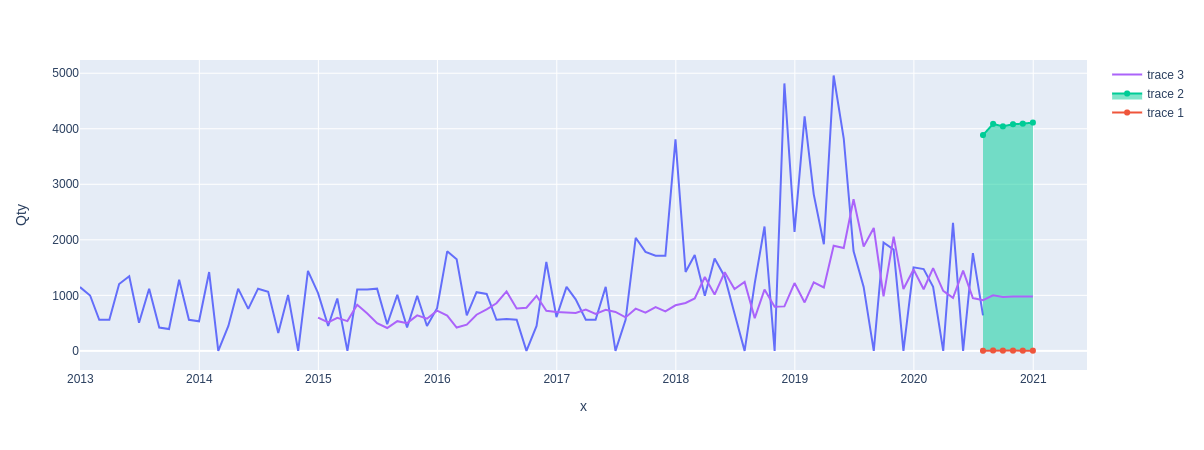

In [ ]:
import plotly.graph_objects as go
fig=px.line(data_frame=df2,x=df2.index,y='Qty')
fig.add_scatter(x=cint.index,y=cint['lower y'])
fig.add_scatter(x=cint.index,y=cint['upper y'],fill='tonexty')
fig.add_scatter(x=ff.index,y=ff['pred'])
#fig2=px.area(cint)
#fig.add_trace()

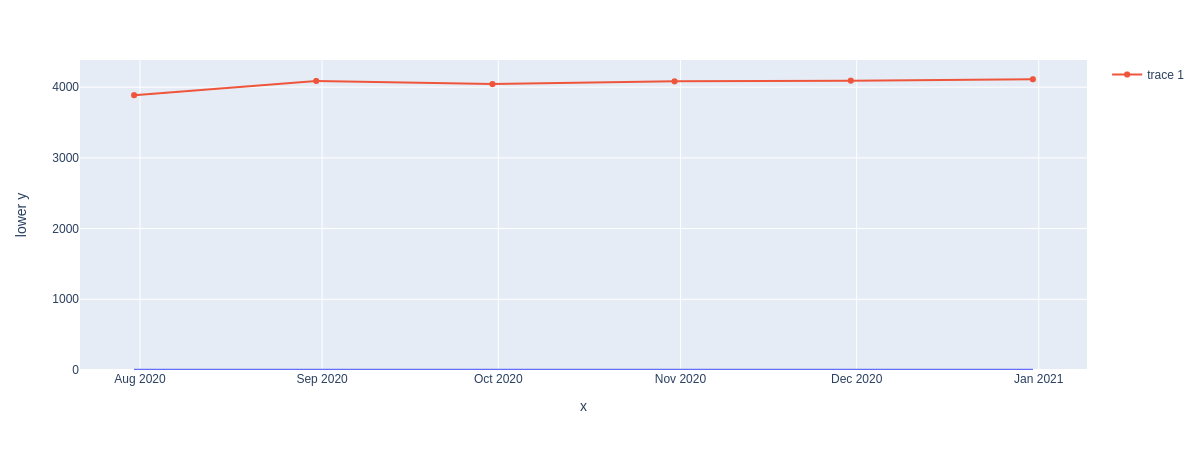

In [ ]:
fig2=px.area(cint,x=cint.index,y='lower y')
fig2.add_scatter(x=cint.index,y=cint['upper y'])

In [ ]:
px.line(data_frame=df2,x=df2.index,y='Qty')

ValueError: All arguments should have the same length. The length of argument `error_y` is 6, whereas the length of previous arguments ['x', 'Qty'] is 98

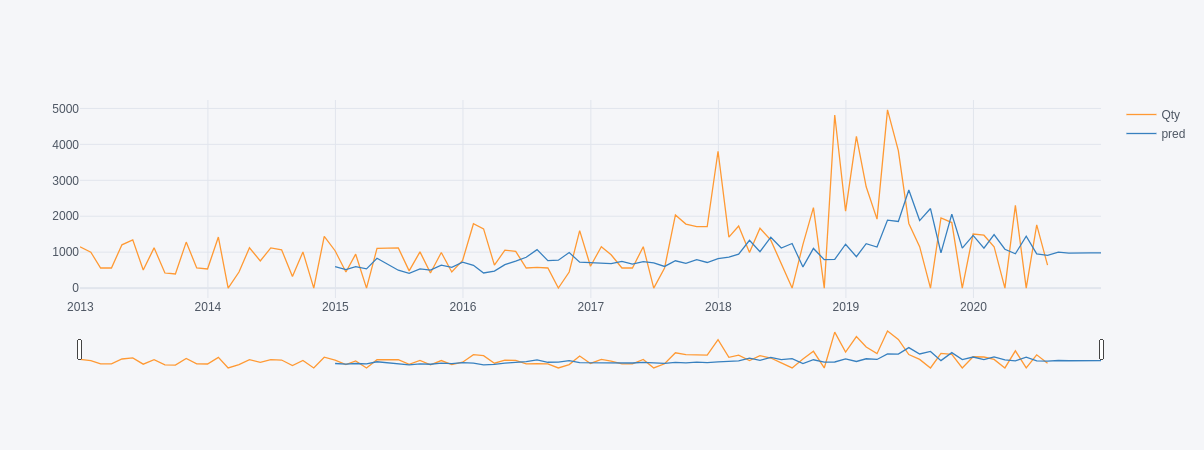

In [ ]:
df2.iplot(rangeslider=True)

In [ ]:
df2=df1.copy()
df2['pred']=ff
df2.iplot(rangeslider=True)
#pre.iplot()

ValueError: cannot reindex from a duplicate axis

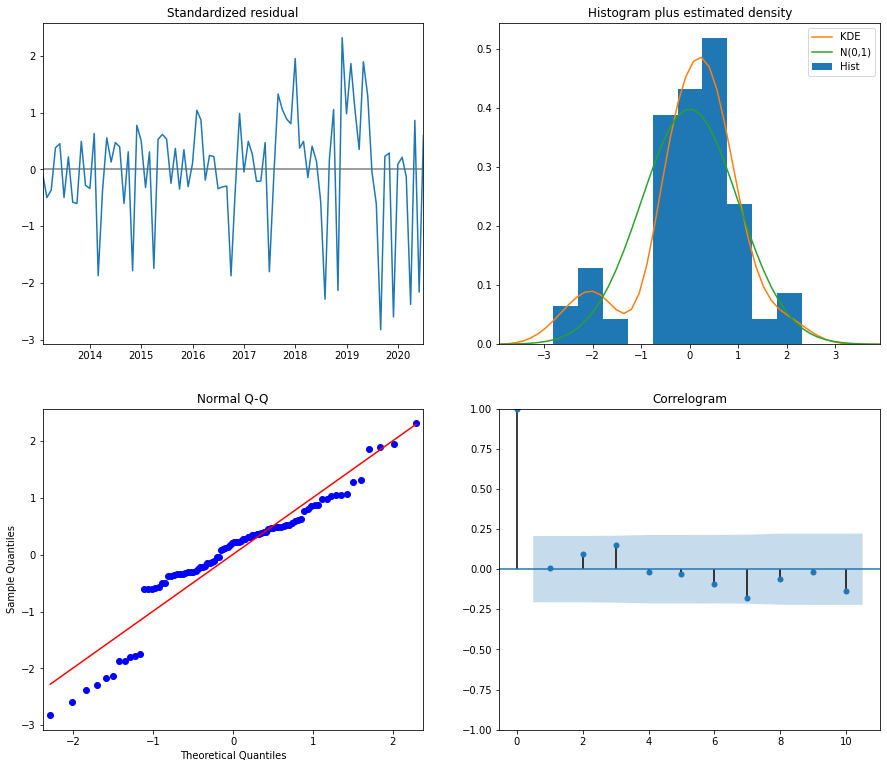

In [ ]:
kk=mod.plot_diagnostics()
kk.set_size_inches(15,13)
#tls.mpl_to_plotly(kk)

In [ ]:
adf=pmd.arima.ADFTest(alpha=.05)
adf.should_diff(df1[['Qty']])

(0.20773737961567418, True)

In [ ]:
from pmdarima.arima import ndiffs
ndiffs(df1, alpha=0.05, test='kpss', max_d=6)

1

In [ ]:
ndiffs(df1, alpha=0.05, test='adf', max_d=6)

1

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(df1)

Results of Dickey-Fuller Test:
Test Statistic                 -5.532989
p-value                         0.000002
#Lags Used                      0.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [ ]:
df2=df1[['Qty']].diff(1)

In [ ]:
adf_test(df2.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.621722e+00
p-value                        6.013716e-09
#Lags Used                     4.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64


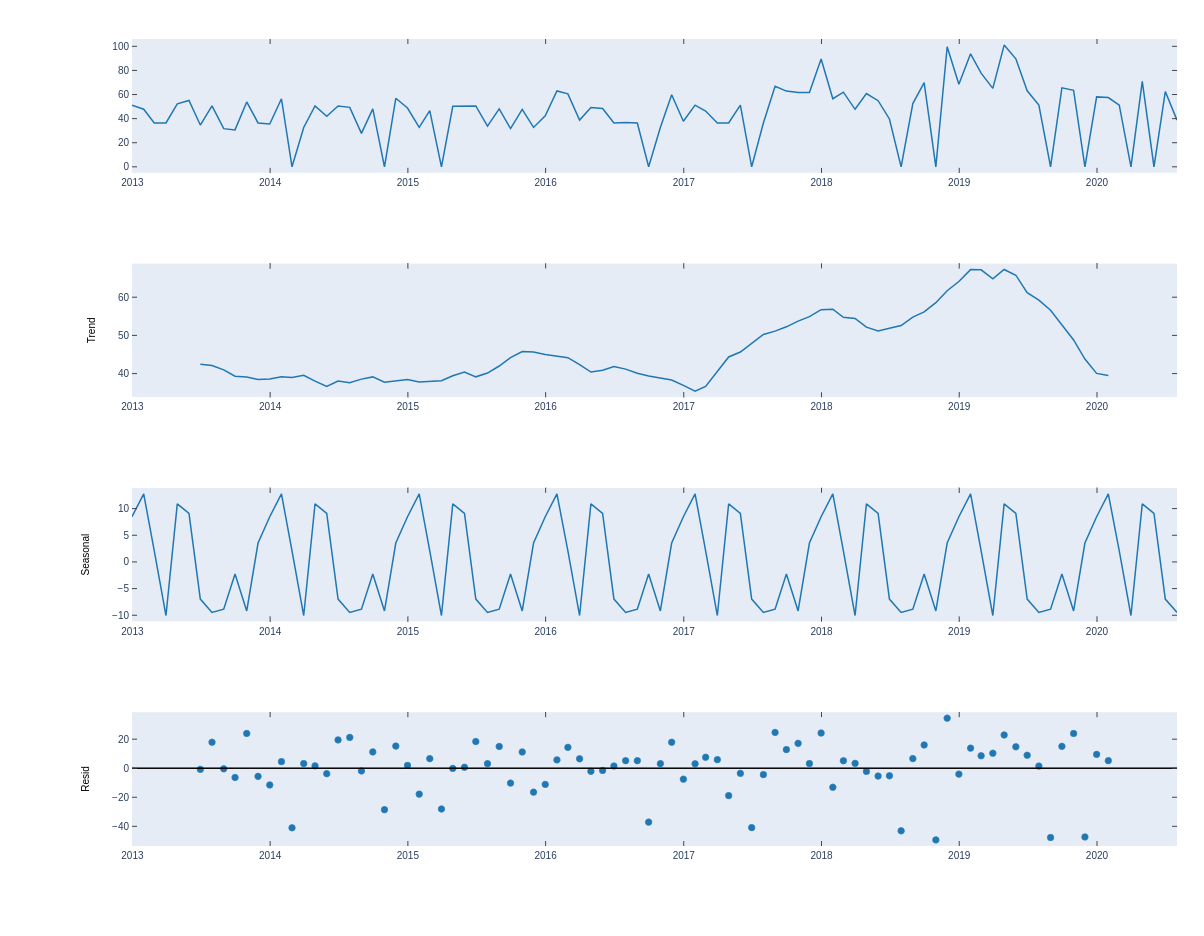

In [ ]:
#plt.figure(figsize=(15,10))
#from plotly.plotly import plot_mpl
hh=seasonal_decompose(x=df3,model='additive').plot()
hh.set_size_inches(15,13)
tls.mpl_to_plotly(hh)

In [ ]:
from autoplotter import run_app
run_app(df)

ImportError: cannot import name 'MATCH' from 'dash.dependencies' (/home/swastik/.local/lib/python3.8/site-packages/dash/dependencies.py)

In [ ]:
cf.set_config_file(offline_show_link=False)

In [ ]:
model1 = pmd.arima.auto_arima(df1['Qty'], start_p=1, start_q=1,start_P=1, start_Q=1, m=12,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,stepwise=True)

In [ ]:
model1

ARIMA(order=(1, 1, 2), seasonal_order=(0, 0, 0, 12))